# Prior and Posterior predictive checks

Use linear fitting process to get head round using checks etc.

## imports

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pymc as pm
import xarray as xr
import preliz as pz
import arviz as az
from scipy.optimize import curve_fit
from scipy.interpolate import PchipInterpolator


## data creation

### model:
$y_i=\alpha + \beta\times x_i$

In [3]:
N = 25 # no. of data points
# values to generate the synthetic data from
true_alpha = 4.0
true_beta = 0.5
true_sd = 0.5

# Generate data
x = 10 * np.random.rand(N)
y = true_alpha + true_beta*x # straight line
y = np.random.normal(y, scale=true_sd) # random.normal(loc=0.0, scale=1.0, size=None)

## Data visualisation
Include "true" line and standard linear regression fit

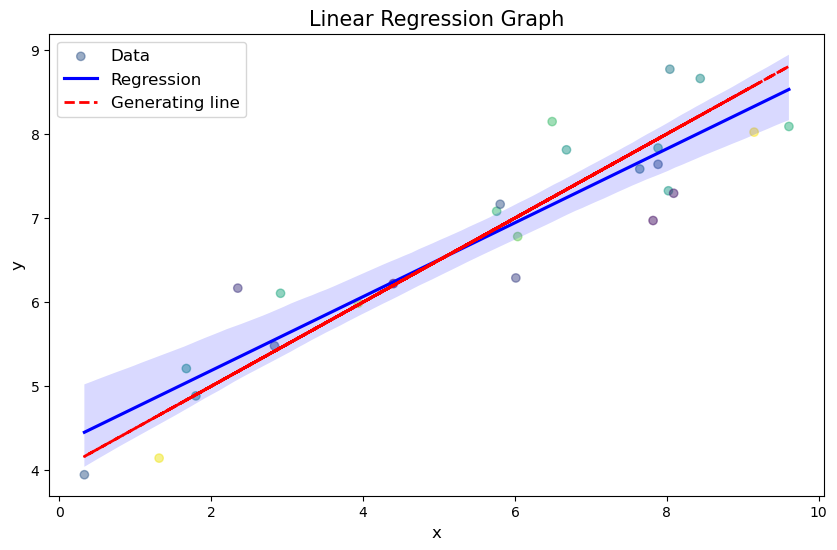

In [4]:
# Plotting the data into a scatter graph, formatting & plotting regression line
colors = np.random.rand(N)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Linear Regression Graph', size = 15)
ax.set_xlabel('x', fontsize = 12)
ax.set_ylabel('y', fontsize = 12)
scatr = plt.scatter(x=x, y=y, c=colors, alpha=0.5, label='Data' )
sns.regplot(x=x, y=y, scatter=False, scatter_kws={'alpha':0.1, 'color':'black'}, line_kws={'color':'blue'},label='Regression'); 
line, = plt.plot(x,true_alpha + true_beta*x , 'r--', lw=2, label="Generating line")
# Fitting legend
ax.legend( fontsize = 12);

Notice that the regression line is close to the 'True' line

## Bayesian approach

### Linear model with predictor variable (x)

$$ \alpha \sim \textnormal{`a prior'}$$
$$ \beta \sim \textnormal{`a n other prior'}$$
$$ \sigma \sim \textnormal{`y a other prior'}$$
$$\mu = \alpha + \beta X$$
$$ Y \sim \mathscr{N}(\mu,\sigma) $$

Model describes a linear relationship between X and Y. Slope is $\beta$ and intercept is $\alpha$. Noise term $\sigma$ means that the relationship is probablistic rather than deterministic.

### Priors

$\alpha$ and $\beta$ can take on any real values – use a normal prior for them.

$\sigma$ will be a positive number - use a HalfNormal prior (could also use an exponential prior)

Models can be visualised with the PreliZ library


In [17]:
# x2 = np.linspace(0, 10, 50)

def a_preliz_model(α_mu, α_sigma, β_mu, β_sigma=5, σ_beta=5):
    α = pz.Normal(α_mu, α_sigma).rvs() # intercept, broad fairly uninformative prior
    β = pz.Normal(β_mu, β_sigma).rvs() # slope use average slope as a start value
    σ = pz.HalfCauchy(σ_beta).rvs()
    #μ = pz.Deterministic("μ", α+β*x)
    Ypred = pz.Normal(β*x2+α, σ).rvs()
    return Ypred

pz.predictive_explorer(a_preliz_model, kind_plot='kde')

In [6]:
midY=np.mean(y)
midX=np.mean(x)
slope_start = midY/midX # mean slope - used in prior
with pm.Model() as lin1:
    α = pm.Normal("α", mu=0, sigma=10) # intercept, broad fairly uninformative prior
    β = pm.Normal("β", mu=midY/midX, sigma=10) # slope use average slope as a start value
    σ = pm.HalfCauchy("σ", 5)
    μ = pm.Deterministic("μ", α+β*x)
    Ypred = pm.Normal("Ypred", mu=μ, sigma=σ, observed=y)
    inferenceData = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Look at results
Begin by looking at the marginal distributions for α, β, and σ

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

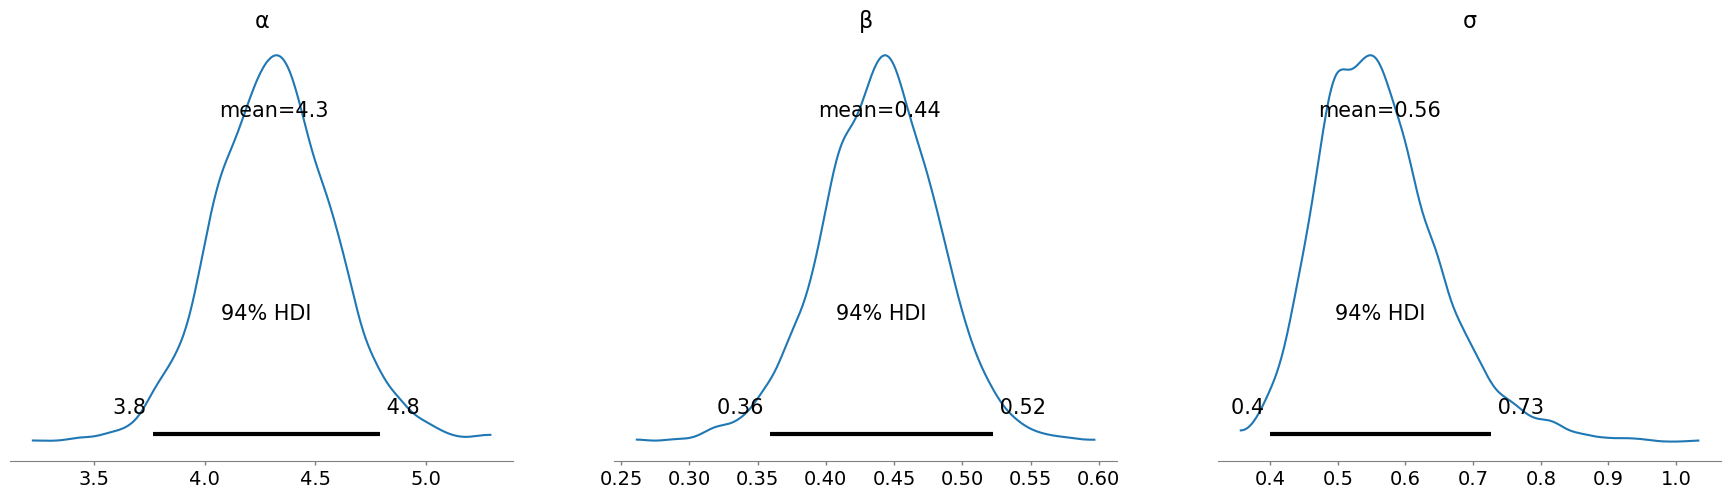

In [7]:
az.plot_posterior(inferenceData, var_names=['~μ']) # note use of ~ to negate outputting mu values

#### Visualizing the uncertainty 
1. Plot of mean along with 50 samples from posterior
2. Plot of 94% HDI based on all samples

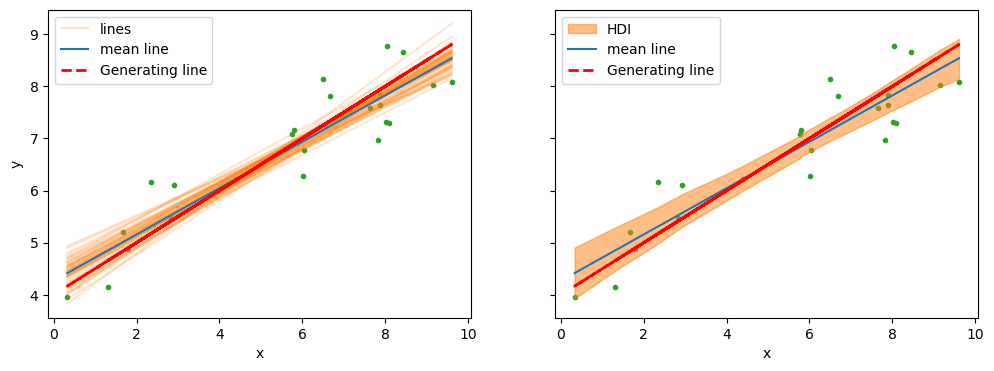

In [8]:
posterior = az.extract(inferenceData, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(np.min(x), np.max(x), 50), dims="plot_id"
)
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot
lines = posterior["α"] + posterior["β"] * x_plot
hdi_lines = az.hdi(inferenceData.posterior["μ"]) # highest data interval (minimal credible range)


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(x, y, "C2.", zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, mean_line, c="C0", label="mean line")
axes[0].plot(x,true_alpha + true_beta*x , 'r--', lw=2, label="Generating line")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].legend()

axes[1].plot(x, y, "C2.", zorder=-3)
idx = np.argsort(x)
axes[1].fill_between(
    x[idx],
    hdi_lines["μ"][:, 0][idx],
    hdi_lines["μ"][:, 1][idx],
    color="C1",
    label="HDI",
    alpha=0.5,
)
axes[1].plot(x_plot, mean_line, c="C0", label="mean line")
axes[1].plot(x,true_alpha + true_beta*x , 'r--', lw=2, label="Generating line")
axes[1].set_xlabel("x")
axes[1].legend()
#plt.savefig("../fig/linear_bikes_posterior_lines.png")

Note that the 'best' fits are essentially the same as the linear regression results - for Normal errors and uninformative priors they would be exactly the same. 

The Bayesain analysis gives the measures of uncertainty + easy extension to more involved models/distributions.

## Interpretting the posterior predictions

Can use the model to create predictive samples:

In [9]:
pm.sample_posterior_predictive(inferenceData, model=lin1, extend_inferencedata=True, random_seed=123)

Sampling: [Ypred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'y')

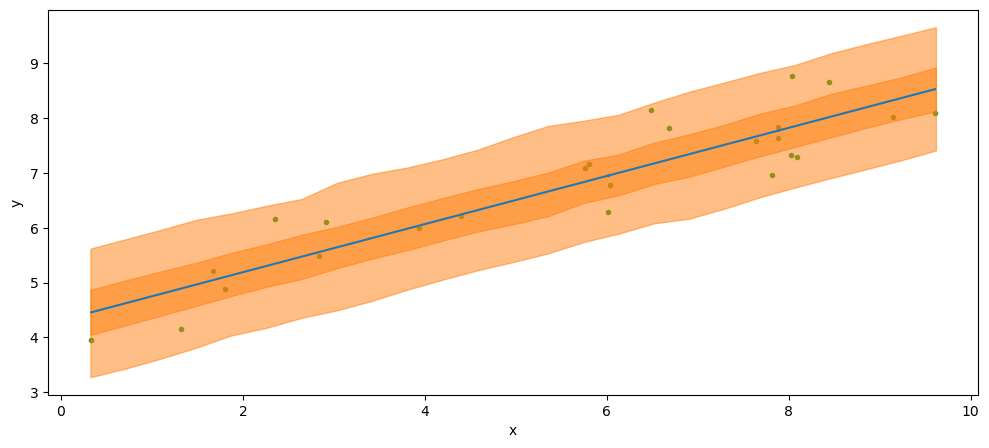

In [10]:
# Plot of the posterior predictions
mean_line = inferenceData.posterior["μ"].mean(("chain", "draw"))
NewxVals = np.random.normal(x, 0.01) # create some new x values (original + noise)
idx = np.argsort(NewxVals) # index (sorted mapping of the x values)
x_pred = np.linspace(NewxVals.min(), NewxVals.max(), 25) # x values in range
# y data based on the quartiles 
y_pred_q = inferenceData.posterior_predictive["Ypred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(NewxVals[idx], y_pred_q[i][idx])(x_pred)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "C2.", zorder=-3)
ax.plot(x[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x_pred, lb, ub, color="C1", alpha=0.5)


ax.set_xlabel("x")
ax.set_ylabel("y")